# REVIEW ASPECT CLASSIFICATION
--------
#### Dataset used aspect annotated restaurant reviews.
#### Required Libraries Sklearn, NLTK, Gensim, matplotlib, pandas

In [1]:
import re
import nltk
import gensim
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
%matplotlib inline

aspect_map={0:"NASP",1:"ASP"}
stemmer = PorterStemmer()

#### Functions to read the Annotated Data file and Extract Sentences and Corresponding Aspects

In [2]:
def read_data(path):
    print "Reading Annotated Data File"
    with open("aspect_annoated_file.txt") as f:
        data=f.read()
    return data

def extract(data):
    print "Extracting Sentences and Tags. Generating POS tags for Words."
    data=np.array(data.split("\n\n"))
    data=np.array([d.split("\n") for d in data])[:-1]
    Sentences=[[] for i in range(data.shape[0])]
    Aspects=[[] for i in range(data.shape[0])]
    for i,d in enumerate(data):
        for j,word in enumerate(d):
            x,_y=word.split('\t')
            Sentences[i].append(x)
            Aspects[i].append(_y)
            d[j]=(x,_y)
    data=np.array(data)
    Sentences=np.array(Sentences)
    Aspects=np.array(Aspects)
    POSTags = nltk.pos_tag_sents(Sentences)
    for i, sent in enumerate(POSTags):
        POSTags[i]=[l for w,l in sent]
    return Sentences, zip(Aspects, POSTags)

#### Function to extract features from  a given word. The following features are used-
1. The word itself
2. POS tag of the word
3. Word position last or first?
4. Word upper case and lower case features
5. Context through previous word and next word
6. Context through previous POS tag and next POS tag.
7. Aspect of previous word

In [3]:
def features(sentence, aspect, pos, index):
    ft_dict={
        'word': sentence[index],
        'wordPOS': pos[index],
        'isFirst': index == 0,
        'isLast': index == len(sentence) - 1,
        'isCapitalized': sentence[index][0].upper() == sentence[index][0],
        'case': "upper" if sentence[index].upper() == sentence[index] else "lower",
        'prevWord': '' if index == 0 else sentence[index - 1],
        'nextWord': '' if index == len(sentence) - 1 else sentence[index + 1],
        #'hyphen': True if sentence[index].find("-") else False,
        #'prevWord2': '' if index in [0,1] else stemmer.stem(sentence[index - 2].lower()),
        #'nextWord2': '' if index in [len(sentence)-1,len(sentence)-2]  else stemmer.stem(sentence[index + 2].lower()),
        'prevPOS': '' if index == 0 else pos[index-1],
        'nextPOS': '' if index == len(sentence) - 1 else pos[index + 1],
        #'prevPOS2': '' if index in [0,1] else pos[index-2],
        #'nextPOS2': '' if index in [len(sentence)-1,len(sentence)-2] else pos[index + 2],
        'prevASP': '' if index == 0 else aspect[index - 1],
    }
    return ft_dict

#### Function to convert the given annotated data to corresponding features (X) and aspects (y), ready to be fed to the machine learning model

In [4]:
def generate_features(Sentences, Aspects, POSTags):
    print "Generating Features X and Labels y"
    def checkaspect(aspect):
        if aspect=="ASP":
            return 1
        else:
            return 0
        return 0
    X = np.array([])
    for i,s in enumerate(Sentences):
        for j, w in enumerate(s):
            X = np.append(X,features(s, Aspects[i],POSTags[i],j))
    y = np.array([])
    for i,l in enumerate(Aspects):
        y = np.append(y, map(lambda x: checkaspect(x), l))
    y = y.ravel()
    return X,y

#### Data Conversion to Features and Labels and POS.
#### Splitting the data into training dataset and testing dataset

In [5]:
data = read_data("")
Sentences, Labels = extract(data)
Sentences, Sentences_test, Labels, Labels_test = train_test_split(Sentences, Labels, test_size=0.25, random_state=100)
Aspects=[a for a,p in Labels]
POSTags=[p for a,p in Labels]
Aspects_test=[a for a,p in Labels_test]
POSTags_test=[p for a,p in Labels_test]
X_train,y_train = generate_features(Sentences,Aspects,POSTags)
X_test,y_test = generate_features(Sentences_test,Aspects_test,POSTags_test)

Reading Annotated Data File
Extracting Sentences and Tags. Generating POS tags for Words.
Generating Features X and Labels y
Generating Features X and Labels y


#### Converting the feature dictionaries to a unique fixed length one-hot vector  

In [6]:
vect= DictVectorizer()
X_train=vect.fit_transform(X_train)
X_test=vect.transform(X_test)

##### Example one-hot feature vector

In [7]:
df=pd.DataFrame(data=X_train.toarray(),columns=vect.feature_names_[::-1])
print df.columns
df.sample(frac=1).head()

Index([u'wordPOS=WRB', u'wordPOS=WP', u'wordPOS=WDT', u'wordPOS=VBZ',
       u'wordPOS=VBP', u'wordPOS=VBN', u'wordPOS=VBG', u'wordPOS=VBD',
       u'wordPOS=VB', u'wordPOS=UH',
       ...
       u'nextPOS=.', u'nextPOS=,', u'nextPOS=)', u'nextPOS=(', u'nextPOS=',
       u'isLast', u'isFirst', u'isCapitalized', u'case=upper', u'case=lower'],
      dtype='object', length=6343)


,wordPOS=WRB,wordPOS=WP,wordPOS=WDT,wordPOS=VBZ,wordPOS=VBP,wordPOS=VBN,wordPOS=VBG,wordPOS=VBD,wordPOS=VB,wordPOS=UH,...,nextPOS=.,"nextPOS=,",nextPOS=),nextPOS=(,nextPOS=,isLast,isFirst,isCapitalized,case=upper,case=lower
244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5155,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6533,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4380,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Using a Linear Support Vector Classificication machine learning model to fit the word features to corresponding aspects

In [8]:
clf = LinearSVC()
clf.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

#### Using the trained model, generating predictions on the words present in the test dataset. 
### Word Level Accuracy
-----------
#### Displaying "Word Level Accuracy" results

In [9]:
preds=clf.predict(X_test)
print "\t\t\tModel Performance Metrics\n"
print classification_report(y_test, preds)

			Model Performance Metrics

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      3154
        1.0       0.97      0.92      0.95       362

avg / total       0.99      0.99      0.99      3516



#### Function for plotting confusion matrix.

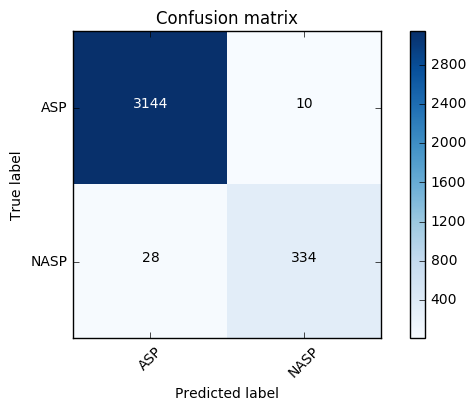

In [10]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix=confusion_matrix(y_test,preds)
plt.figure()
class_names=["ASP","NASP"]
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix')

#### Function to plot the ROC Curve.

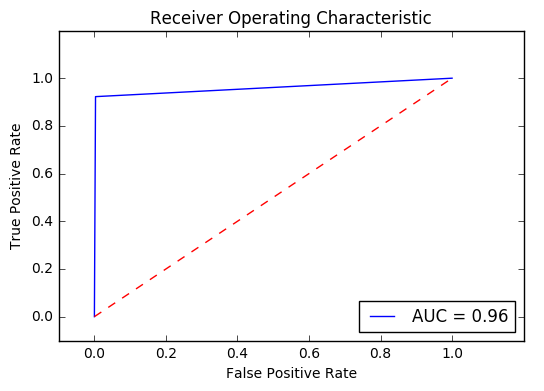

In [11]:
def plot_roc_curve(true, predicted):
    fpr,tpr,t=roc_curve(true,predicted)
    roc_auc=auc(fpr,tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
plot_roc_curve(y_test,preds)

### Sentence Level Accuracy
----------
#### Function for calculating Sentence Level Accuracy.

In [12]:
def sentence_accuracy(Sentences, POSTags, OrigTags):
    count=0
    print "Examples where model is wrong: \n\n"
    asp=[]
    for i, sent in enumerate(Sentences):
        inp=sent
        pos=POSTags[i]
        tags,predasp,orasp=[],[],[]
        for j, w in enumerate(inp):
            fts=vect.transform(features(inp,tags,pos,j))
            tags.append(aspect_map[clf.predict(fts)[0]])
            if tags[j]=="ASP":
                predasp.append(w)
                asp.append(w)
            if OrigTags[i][j]=="ASP":
                orasp.append(w)     
        if set(predasp)==set(orasp):
            count+=1
        else:
            print "Text: ", " ".join(sent)
            print "Original Aspects", set(orasp)
            print "Predicted Aspects", set(predasp)
            print
    return "Sentence Level Accuracy: " + str(float(count)/Sentences.shape[0]*100)+ "%", asp

In [13]:
results, pred_asp_train = sentence_accuracy(Sentences_test, POSTags_test, Aspects_test)
print "\n"+results

Examples where model is wrong: 


Text:  I go and eat out at many different restaurants and this is one place you have go and try .
Original Aspects set(['place'])
Predicted Aspects set([])

Text:  Furthermore , the rice had no seasoning , so the sushi was bland and disgusting .
Original Aspects set(['seasoning', 'rice', 'sushi'])
Predicted Aspects set(['rice', 'sushi'])

Text:  Sit outside in the warm weather; inside for cozy winter .
Original Aspects set(['winter'])
Predicted Aspects set([])

Text:  The atmosphere is unheralded , the service impecible , and the food magnificant .
Original Aspects set(['food', 'atmosphere', 'service', 'impecible'])
Predicted Aspects set(['food', 'atmosphere', 'service'])

Text:  I found the food to be outstanding , particulary the salmon dish I had .
Original Aspects set(['food', 'dish', 'salmon'])
Predicted Aspects set(['food', 'dish'])

Text:  this is can became on e of the NY Italian Food fare institutions .
Original Aspects set(['Food', 'fare'])
P

#### Function for annotating an input sentence with the corresponding aspects

In [14]:
def tag_sentence(sent):
    inp=re.findall(r'\w+|\S+', sent)
    pos=nltk.pos_tag(inp)
    tags,asp,buf=[],[],""
    for i, w in enumerate(inp):
        fts=vect.transform(features(inp,tags,pos,i))
        tags.append(aspect_map[clf.predict(fts)[0]])
        if tags[i]=="ASP":
            asp.append(w)
        if w in asp:
            tags[i]="ASP"
        buf+=w+"\\"+tags[i]+" "
    print "Key Aspects: ", set(asp), "\n"
    return buf,asp

### Some Examples:
----------

In [15]:
sentence="The waiter was rude, but the music was good!"
tagged_sent, pred_asp=tag_sentence(sentence)
print tagged_sent

Key Aspects:  set(['waiter', 'music']) 

The\NASP waiter\ASP was\NASP rude\NASP ,\NASP but\NASP the\NASP music\ASP was\NASP good\NASP !\NASP 


In [16]:
sentence='''It's ambience is what makes it different from other places. \
            Although the jungle theme is quite attractive but the illumination just \
            gave us migraine! The food is okay-ish. Too much variety but not delicious \
            at all. Last but not the least, the staff is just horrible! All our requests \
            went unheeded. Never seen a service this bad! We kept waiting for starters but \
            the staff was least bothered. I will definitely not recommend this place.'''
tagged_sent, pred_asp=tag_sentence(sentence)
print tagged_sent

Key Aspects:  set(['ambience', 'food', 'place', 'service', 'staff']) 

It\NASP 's\NASP ambience\ASP is\NASP what\NASP makes\NASP it\NASP different\NASP from\NASP other\NASP places\NASP .\NASP Although\NASP the\NASP jungle\NASP theme\NASP is\NASP quite\NASP attractive\NASP but\NASP the\NASP illumination\NASP just\NASP gave\NASP us\NASP migraine\NASP !\NASP The\NASP food\ASP is\NASP okay\NASP -ish.\NASP Too\NASP much\NASP variety\NASP but\NASP not\NASP delicious\NASP at\NASP all\NASP .\NASP Last\NASP but\NASP not\NASP the\NASP least\NASP ,\NASP the\NASP staff\ASP is\NASP just\NASP horrible\NASP !\NASP All\NASP our\NASP requests\NASP went\NASP unheeded\NASP .\NASP Never\NASP seen\NASP a\NASP service\ASP this\NASP bad\NASP !\NASP We\NASP kept\NASP waiting\NASP for\NASP starters\NASP but\NASP the\NASP staff\ASP was\NASP least\NASP bothered\NASP .\NASP I\NASP will\NASP definitely\NASP not\NASP recommend\NASP this\NASP place\ASP .\NASP 


In [17]:
sentence='''IPL season and microbreweries are a match made in heaven. The only downer to this is being
            able to find parking and getting a table. Battling the crowds we were able to visit Downtown
            recently and thanx to the really nice and courteous staff, we were able to get a table shortly. 
            Downtown occupies a massive place and has space for many covers, but thanx to its popularity
            it's always busy. Somehow the staff does a good job of keeping up even on the busiest days. 
            We ordered  beer, chicken tikka pizza, chilly chicken, chilly fish and alfredo pasta . 
            The wheat beer and the pizzas stood out and were superb. The chilly chicken and chilly fish 
            were good. The pasta was average. Overall downtown provides good decor, great food and service. 
            The only thing I wish were better, was the music, which was very inconsistent and old-ish on 
            the day I went.'''
tagged_sent, pred_asp=tag_sentence(sentence)
print tagged_sent

Key Aspects:  set(['decor', 'service', 'music', 'food', 'fish', 'visit', 'place', 'pasta', 'table', 'chicken', 'staff', 'pizza']) 

IPL\NASP season\NASP and\NASP microbreweries\NASP are\NASP a\NASP match\NASP made\NASP in\NASP heaven\NASP .\NASP The\NASP only\NASP downer\NASP to\NASP this\NASP is\NASP being\NASP able\NASP to\NASP find\NASP parking\NASP and\NASP getting\NASP a\NASP table\ASP .\NASP Battling\NASP the\NASP crowds\NASP we\NASP were\NASP able\NASP to\NASP visit\ASP Downtown\NASP recently\NASP and\NASP thanx\NASP to\NASP the\NASP really\NASP nice\NASP and\NASP courteous\NASP staff\ASP ,\NASP we\NASP were\NASP able\NASP to\NASP get\NASP a\NASP table\ASP shortly\NASP .\NASP Downtown\NASP occupies\NASP a\NASP massive\NASP place\ASP and\NASP has\NASP space\NASP for\NASP many\NASP covers\NASP ,\NASP but\NASP thanx\NASP to\NASP its\NASP popularity\NASP it\NASP 's\NASP always\NASP busy\NASP .\NASP Somehow\NASP the\NASP staff\ASP does\NASP a\NASP good\NASP job\NASP of\NASP keeping\N

In [18]:
sentence='''Dinner at this Restaurant, which has copied every bit of from Barbeque Nation, was just okay 
            , no great milkshake . The food was just okay. You might like the food if this is your first time
            ever to such restaurants. Service is good , the guys waiting at the table was courteous, prompt 
            n fast. They knew it's a holiday , hence the rush and ensured all guests are welcomed. The only
            thing that struck my good sense was the overtly loud music by this live band. The loud music n
            people talking loudly as they placed their orders was not a good feeling. I love eating at a 
            quite place. But this restaurant is synonymous to the word DIN.'''
tagged_sent, pred_asp=tag_sentence(sentence)
print tagged_sent

Key Aspects:  set(['Service', 'people', 'food', 'restaurant', 'music', 'place', 'time', 'table']) 

Dinner\NASP at\NASP this\NASP Restaurant\NASP ,\NASP which\NASP has\NASP copied\NASP every\NASP bit\NASP of\NASP from\NASP Barbeque\NASP Nation\NASP ,\NASP was\NASP just\NASP okay\NASP ,\NASP no\NASP great\NASP milkshake\NASP .\NASP The\NASP food\ASP was\NASP just\NASP okay\NASP .\NASP You\NASP might\NASP like\NASP the\NASP food\ASP if\NASP this\NASP is\NASP your\NASP first\NASP time\ASP ever\NASP to\NASP such\NASP restaurants\NASP .\NASP Service\ASP is\NASP good\NASP ,\NASP the\NASP guys\NASP waiting\NASP at\NASP the\NASP table\ASP was\NASP courteous\NASP ,\NASP prompt\NASP n\NASP fast\NASP .\NASP They\NASP knew\NASP it\NASP 's\NASP a\NASP holiday\NASP ,\NASP hence\NASP the\NASP rush\NASP and\NASP ensured\NASP all\NASP guests\NASP are\NASP welcomed\NASP .\NASP The\NASP only\NASP thing\NASP that\NASP struck\NASP my\NASP good\NASP sense\NASP was\NASP the\NASP overtly\NASP loud\NASP music\

### Experimentation with Word2Vec and clustering Similar Aspects.
----------

#### Using Gensim loading Google's pretrained Word2Vec model

In [19]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

#### Reading a list of most common aspects

In [20]:
with open("aspect_words_1k_restaurant_reviews") as f:
    data = f.readlines()

#### Function to the convert the most common aspects list into corresponding word vectors.

In [21]:
def load_word_vectors(data, save=None):
    data=np.unique([d.replace('\n','').lower() for d in data])
    word_vectors=[]
    first=True
    for i,d in enumerate(data):
        try:
            word_vectors.append([[d],model.word_vec(d)])
        except:
            if first:
                print "Word2Vec model cannot find the following words: "
                first=False
            print "Not Found: ", d
    print
    if save!=None:
        np.save(save, word_vectors)
    names=[word for word,vec in word_vectors]
    vectors=[vec for word,vec in word_vectors]
    return names, vectors

#### Unsupervised Machine Learning model for Clustering similar words based on word embeddings using Word2Vec.

In [27]:
clf2=KMeans(n_clusters=6, random_state=100)
names_train, vectors_train= load_word_vectors(data)
clf2.fit(vectors_train)

Word2Vec model cannot find the following words: 
Not Found:  apppetizer
Not Found:  atmoshere
Not Found:  candle-light
Not Found:  daiquiry
Not Found:  decour
Not Found:  food-quality
Not Found:  impecible
Not Found:  joya
Not Found:  maus
Not Found:  menu-fare
Not Found:  model/waitress
Not Found:  moule
Not Found:  mozzarellum
Not Found:  panchetta
Not Found:  penang
Not Found:  raddichio
Not Found:  refleshment
Not Found:  sangrium
Not Found:  sashimus
Not Found:  trattorium



KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=100, tol=0.0001, verbose=0)

#### Using the trained model displaying currently Clustered Aspects

In [28]:
def print_clusters(labels, names, ret=None):
    clusters=[[] for i in range(clf2.n_clusters)]
    for i,label in enumerate(labels):
        clusters[label].append(names[i][0])
    for i, c in enumerate(clusters):
        print "Cluster",i,":", ", ".join(c)
        print
    if ret:
        return clusters
print_clusters(clf2.labels_, names_train)

Cluster 0 : appetizer, bagel, bistro, branzino, cheeseburger, chef, chow, crust, cuisine, deli, dessert, dish, dosa, dumpling, entree, filet, fries, meal, menu, noodle, pancake, pasta, pastrami, pastry, patty, pie, pizza, pizzeria, ravioli, restaurant, sandwich, soup, spaghetti, steak, sushi, takeout, tempura, waiter, waitress

Cluster 1 : ambience, anything, atmosphere, charm, conversation, crowd, delight, experience, flair, flavor, friend, fun, kid, laugh, music, noise, perfection, relaxing, reviewer, something, sound, stuff, style, taste, vibe

Cluster 2 : beef, cheese, chicken, guacamole, lettuce, mayo, pepper, potato, rice, salad, sauce, scallion, seasoning

Cluster 3 : caviar, crab, fish, halibut, lobster, oyster, salmon, seafood, shrimp, tuna, yellowtail

Cluster 4 : banquet, bar, bathroom, beer, bottle, breast, cream, decor, dining, dinner, drink, entertainment, fare, fat, food, glass, hall, hostess, japan, juice, kiosk, lawn, lunch, mouth, neighborhood, palate, patron, plate, 

#### Assigning Clusters to the predicted aspects obtained through model-1 (LinearSVC)

In [29]:
name_test, vectors_test=load_word_vectors(pred_asp_train)
pred_clus=clf2.predict(vectors_test)
print_clusters(pred_clus, name_test)

Word2Vec model cannot find the following words: 
Not Found:  consistency-not

Cluster 0 : appetizer, bagel, bistro, chef, crust, cuisine, dessert, dish, fries, meal, menu, pie, pizza, pizzeria, restaurant, sandwich, sushi, waiter

Cluster 1 : ambience, anything, atmosphere, delight, experience, friend, fun, music, perfection, stuff, taste

Cluster 2 : cheese, chicken, rice, salad, sauce, scallion

Cluster 3 : caviar, crab, fish, lobster, salmon, seafood, shrimp, tuna

Cluster 4 : bar, bathroom, bottle, cream, decor, dining, dinner, entertainment, food, glass, hall, lunch, mouth, neighborhood, room, svc, table, thai, water, wine

Cluster 5 : amount, course, date, establishment, evening, family, favorite, feature, fix, gem, group, husband, location, money, must, notch, order, part, party, people, piece, place, portion, price, quality, roll, saturday, service, setting, size, special, staff, time, town, type, value, view, visit, wait, way, week, work, world



#### Assigning Clusters to a custom list of aspects.

In [30]:
inp_words=["food", "Biriyani", "fish", "song", "staff", "lobster", "restaurant", "mutton",\
           "pork", "sandwich", "icecream", "table", "waiting", "theme", "service",\
           "chicken", "waiter", "ambience", "furniture", "music", "pasta", "pizza", "fillet"]

name_test, vectors_test=load_word_vectors(inp_words)
pred_clus=clf2.predict(vectors_test)

print_clusters(pred_clus, name_test, ret=True)


Cluster 0 : biriyani, fillet, icecream, pasta, pizza, restaurant, sandwich, waiter

Cluster 1 : ambience, music, song, theme

Cluster 2 : chicken, mutton, pork

Cluster 3 : fish, lobster

Cluster 4 : food, furniture, table

Cluster 5 : service, staff, waiting



[['biriyani',
  'fillet',
  'icecream',
  'pasta',
  'pizza',
  'restaurant',
  'sandwich',
  'waiter'],
 ['ambience', 'music', 'song', 'theme'],
 ['chicken', 'mutton', 'pork'],
 ['fish', 'lobster'],
 ['food', 'furniture', 'table'],
 ['service', 'staff', 'waiting']]